</style>
<h1  style="text-align:center;font-size:40px">
    Econometric_analysis_of_wage_repartition
    <h2 style="text-align:center">
    @autor = Valentin Larrieu
    </h2>
</h1>

## Utilities

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import matlib as mb
from scipy.stats import spearmanr, normaltest, f, chi2
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt 
import statsmodels as sm
import seaborn as sns
import scipy
import matplotlib.dates as mdates


sns.set(style='whitegrid')

import warnings
warnings.filterwarnings("ignore")

/home/mickael/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
def compute_pvalue_stat(X,y,nbVar):
    n,k = X.shape
    matriceGram = np.dot(np.transpose(X),X)
    matriceGram_inv = np.linalg.inv(matriceGram)
    beta = np.dot(np.dot(matriceGram_inv,np.transpose(X)),y)
    u = y - np.dot(X,beta)
    sig2 = np.dot(u.T,u)/(n-(nbVar)) #+1
    std = np.sqrt(np.diag(sig2*matriceGram_inv))
    t = beta/std
    SSR = np.dot(u.T,u)
    p_distrib = stats.t.cdf(abs(t) , n-(nbVar)) #+1
    p_value = (1 - p_distrib) * 2
    return beta, u, sig2, std, t, SSR, p_value

## Regression

### Reading and selecting data
We read the data and filter data only to keeep those with positive wage

In [71]:
df = pd.read_csv('Data/MROZ.raw', sep='\s+', header= None )
df = df.rename(columns={0: 'inlf', 1: 'hours', 2: 'kidslt6', 3: 'kidsge6', 4: 'age', 5: 'educ', 6: 'wage',
                        7: 'repwage', 8: 'hushrs', 9: 'husage', 10: 'huseduc', 11: 'huswage', 12: 'faminc',
                        13: 'mtr', 14: 'motheduc', 15: 'fatheduc', 16: 'unem', 17: 'city', 18: 'exper',
                        19: 'nwifeinc', 20: 'lwage', 21: 'expersq'})
df.head()

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
0,1,1610,1,0,32,12,3.354,2.65,2708,34,...,16310,0.7215,12,7,5.0,0,14,10.910060,1.210154,196
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,...,21800,0.6615,7,7,11.0,1,5,19.499980,.3285121,25
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,...,21040,0.6915,12,7,5.0,0,15,12.039910,1.514138,225
3,1,456,0,3,34,12,1.0965,3.25,1920,53,...,7300,0.7815,7,7,5.0,0,6,6.799996,.0921233,36
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,...,27300,0.6215,12,14,9.5,1,7,20.100060,1.524272,49


In [7]:
# Show the field type
df.dtypes

inlf          int64
hours         int64
kidslt6       int64
kidsge6       int64
age           int64
educ          int64
wage         object
repwage     float64
hushrs        int64
husage        int64
huseduc       int64
huswage     float64
faminc        int64
mtr         float64
motheduc      int64
fatheduc      int64
unem        float64
city          int64
exper         int64
nwifeinc    float64
lwage        object
expersq       int64
dtype: object

Exploring the dataframe shows that there is some values set as '.' in the 'wage' and 'lwage' columns. It is  the reason why they have been cast as object and not float. Let's replace those value by 0 and re-cast those columns as float.  

In [8]:
df['wage'].replace(to_replace='.', value=0, inplace=True)
df['lwage'].replace(to_replace='.', value=0, inplace=True)

# Convert the field type for 'wage' & 'lwage'
df['wage']= pd.to_numeric(df['wage'])
df['lwage']= pd.to_numeric(df['lwage'])

In [9]:
# Keep calue where wage positive
n_0 = df.shape[0]
df = df[df['wage']>0]
n_1 = df.shape[0]
print('We drop {} rows which have a negative wage'.format(n_0 - n_1))
print('There is {} left with a positive wage'.format(n_1))

We drop 325 rows which have a negative wage
There is 428 left with a positive wage


### Computation of statistics
Descriptive statistics of salary, age and education are provided for all women and then, for women whose husband's salary is higher than the median of the sample, then for women whose husband's salary is lower than the median of the sample

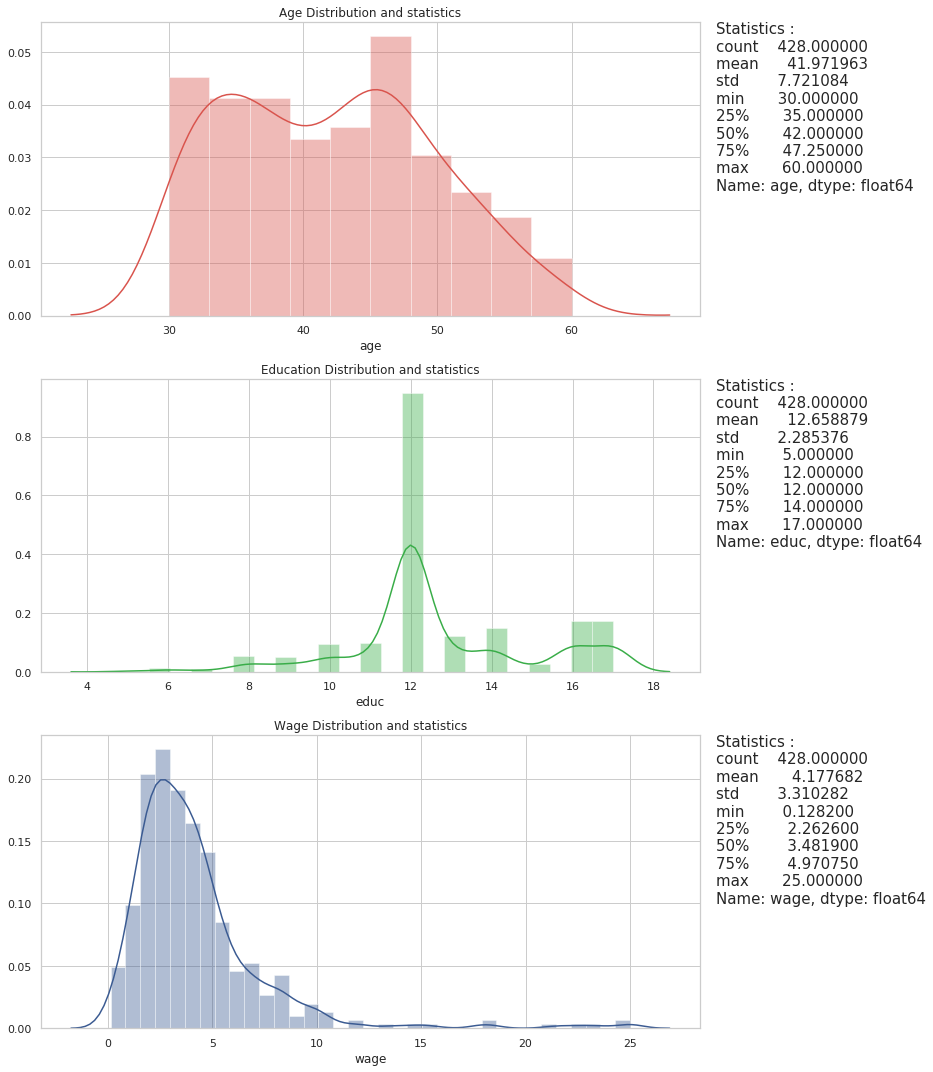

In [10]:
f , (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,15))
ax1.set_title("Age Distribution and statistics")
sns.distplot(df['age'], ax=ax1, color = sns.xkcd_rgb["pale red"]);
plt.figtext(1, 0.82, 'Statistics :\n'+str(df['age'].describe()), axes = ax1, fontsize = 15 )
ax2.set_title("Education Distribution and statistics")
sns.distplot(df['educ'], ax=ax2, color = sns.xkcd_rgb["medium green"] );
plt.figtext(1, 0.49, 'Statistics :\n'+str(df['educ'].describe()), axes = ax2, fontsize = 15 )
ax3.set_title("Wage Distribution and statistics")
sns.distplot(df['wage'], ax=ax3, color = sns.xkcd_rgb["denim blue"]);
plt.figtext(1, 0.16, 'Statistics :\n'+str(df['wage'].describe()), axes = ax3, fontsize = 15 )
plt.tight_layout()
plt.show()

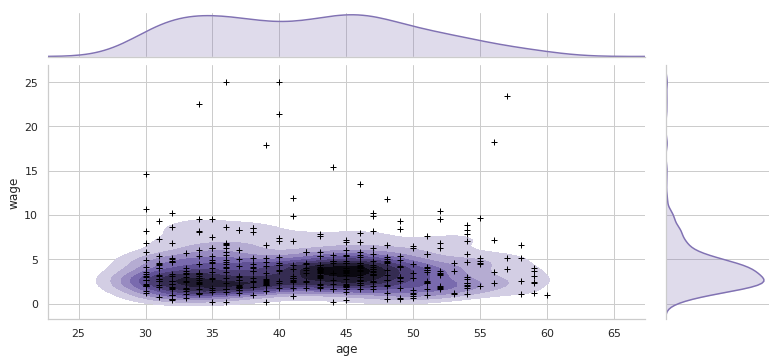

In [11]:
# We will also be interested to plot the relationship between wage & age as well as Wage & eductation
g = sns.jointplot(x="age", y="wage", data=df, kind="kde", color="m")
g.plot_joint(plt.scatter, c="black", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('age', 'wage')
plt.gcf().set_size_inches(12, 5)
plt.show()

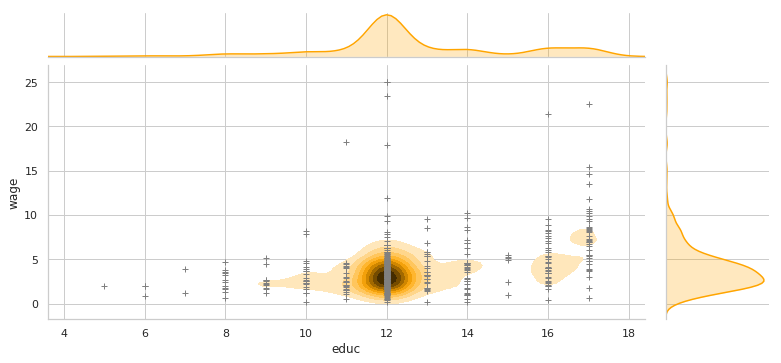

In [12]:
g = sns.jointplot(x="educ", y="wage", data=df, kind="kde", color="orange")
g.plot_joint(plt.scatter, c="gray", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('educ', 'wage')
plt.gcf().set_size_inches(12, 5)
plt.show()

In [13]:
# We will now try to make the same description for woman 
# with husband salary < or > of husbsalary median
huswage_med = np.median(df['huswage'].values)
df_above = pd.DataFrame(columns = ['age','wage','educ'])
df_below = pd.DataFrame(columns = ['age','wage','educ'])
df_above = df_above.append(df[df['huswage'] >= huswage_med][['age','wage','educ']]).astype(float)
df_below = df_below.append(df[df['huswage'] < huswage_med][['age','wage','educ']]).astype(float)

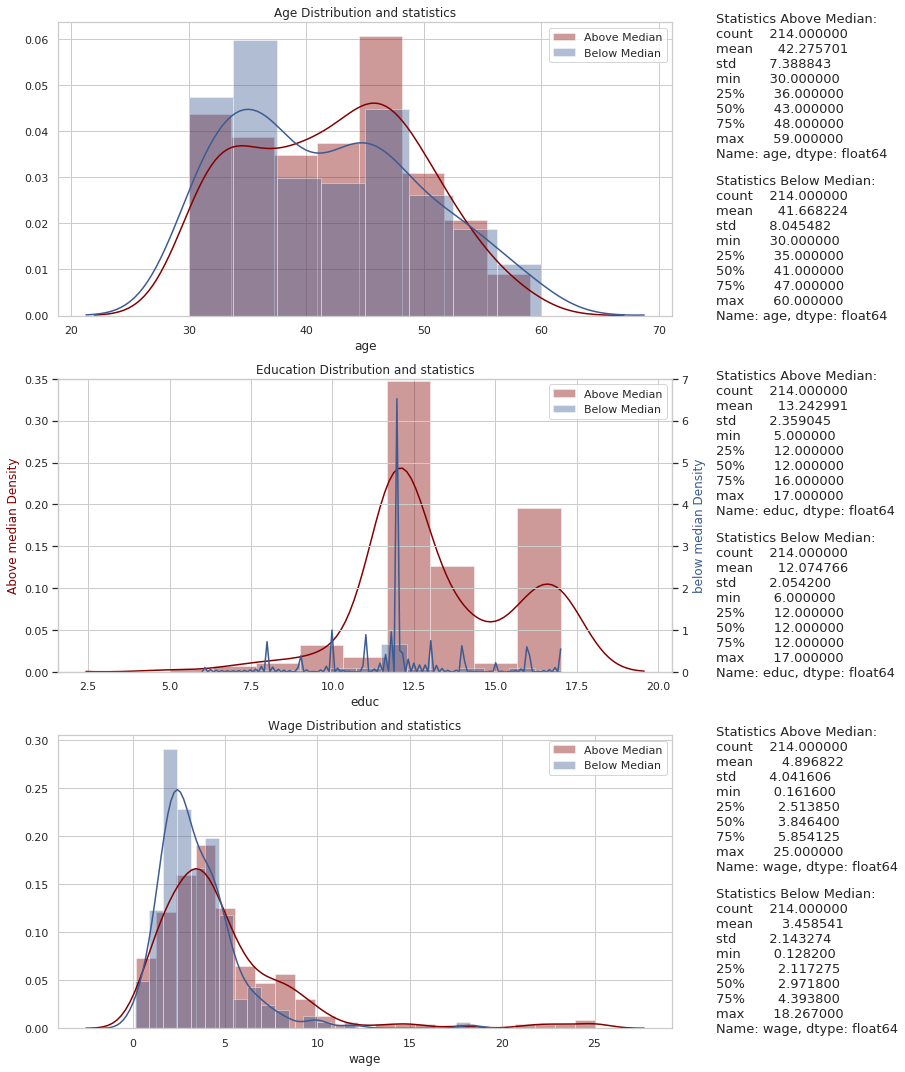

In [14]:
f , (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,15))

ax1.set_title("Age Distribution and statistics")
sns.distplot(df_above['age'], ax=ax1, color = sns.xkcd_rgb["dark red"], label='Above Median')
sns.distplot(df_below['age'], ax=ax1, color = sns.xkcd_rgb["denim blue"], label = 'Below Median')
ax1.legend()
plt.figtext(1, 0.85, 'Statistics Above Median:\n'+str(df_above['age'].describe()), axes = ax1, fontsize = 13 )
plt.figtext(1, 0.7, 'Statistics Below Median:\n'+str(df_below['age'].describe()), axes = ax1, fontsize = 13 )


ax2.set_title("Education Distribution and statistics")
ax21 = ax2.twinx()
# ax2.set_ylabel("lwage")
sns.distplot(df_above['educ'], ax=ax2, color = sns.xkcd_rgb["dark red"], label='Above Median')
sns.distplot(df_below['educ'], ax=ax21, color = sns.xkcd_rgb["denim blue"], label = 'Below Median')
plt.figtext(1, 0.52, 'Statistics Above Median:\n'+str(df_above['educ'].describe()), axes = ax1, fontsize = 13 )
plt.figtext(1, 0.37, 'Statistics Below Median:\n'+str(df_below['educ'].describe()), axes = ax1, fontsize = 13 )

# set the ticks
ax2.set_ylabel("Above median Density")
ax2.yaxis.label.set_color(sns.xkcd_rgb["dark red"])
ax2.set_yticks(np.arange(0,0.4,0.05))
ax2.set_ylim(0,0.35)

ax21.set_ylabel("below median Density")
ax21.yaxis.label.set_color(sns.xkcd_rgb["denim blue"])
ax21.set_yticks(np.arange(0,8,1))
ax21.set_ylim(0,7)

# Set legend
lns1, lab1 = ax2.get_legend_handles_labels()
lns2, lab2 = ax21.get_legend_handles_labels()
ax2.legend(lns1+lns2,lab1+lab2)


ax3.set_title("Wage Distribution and statistics")
sns.distplot(df_above['wage'], ax=ax3, color = sns.xkcd_rgb["dark red"], label='Above Median')
sns.distplot(df_below['wage'], ax=ax3, color = sns.xkcd_rgb["denim blue"], label = 'Below Median')
plt.figtext(1, 0.19, 'Statistics Above Median:\n'+str(df_above['wage'].describe()), axes = ax1, fontsize = 13 )
plt.figtext(1, 0.04, 'Statistics Below Median:\n'+str(df_below['wage'].describe()), axes = ax1, fontsize = 13 )
ax3.legend()

plt.tight_layout()
plt.show()

Based on the graphs, we clearly see a difference of distribution between the woman with a hushband salary abobe and  below median wage. The group "Above median" tends to have a bigger salary and includes more outliers (women with high salary) than the group "below" median.

### Wage histograms comparison
We make the histogram of the wage variable. Calculate the wage log and do the histogram. Compare the two histograms and comment

N.B. : There is also a column 'lwage' (logarithm wage)in the dataset. To double check, we compare our calculation with the lwage of the dataset, which can be seen in the second graph of this part

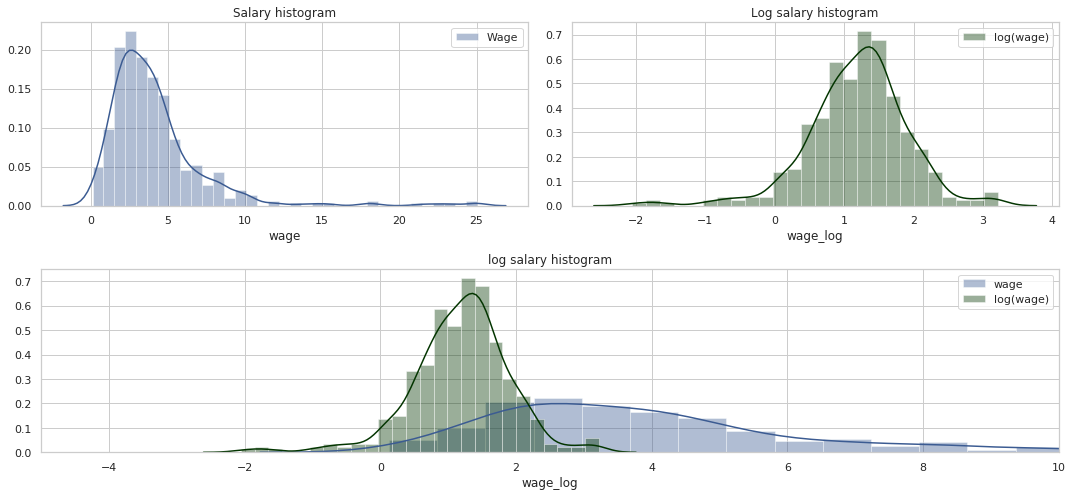

In [15]:
# Wage calculation
df["wage_log"] = np.log(df["wage"])

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(15,7))

gs = axs[1,0].get_gridspec()
axs[1,1].remove()
axs[1,0].remove()

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = fig.add_subplot(gs[1,:])

sns.distplot(df["wage"], label='Wage', color = sns.xkcd_rgb['denim blue'], ax= ax1)
ax1.set_title("Salary histogram")
ax1.legend()
           
sns.distplot(df["wage_log"], label='log(wage)', color = sns.xkcd_rgb['dark green'], ax = ax2)
ax2.set_title("Log salary histogram")
ax2.legend()

sns.distplot(df["wage"], label='wage', color = sns.xkcd_rgb['denim blue'], ax=ax3)
sns.distplot(df["wage_log"], label='log(wage)', color = sns.xkcd_rgb['dark green'], ax=ax3)
ax3.set_title("log salary histogram")
ax3.set_xlim(-5,10)
ax3.legend()

plt.tight_layout()
plt.show()

__Comment__ : 
log wage seems to follow a uniform distribution while the wage values follow a tail distribution. The log function allow to uniformize the function and not be influenced by the outliers (people with high salary).

### Correlation computation 
We calculate the correlations between motheduc and fatheduc

To evaluate the correlation between those tow values, let's use the spearmanr function from scipy. But first let's plot the two values on a graph

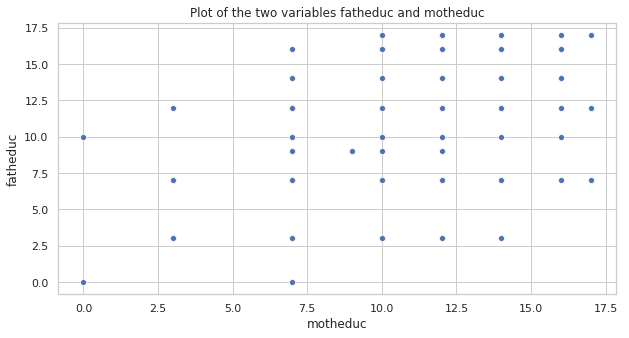

In [16]:
plt.figure(figsize = (10,5))
sns.scatterplot(x="motheduc", y="fatheduc", data=df)
plt.title('Plot of the two variables fatheduc and motheduc')
plt.show()

__Comment__ : We have more than 200 samples for each variables. However, we only see 20 of them in the plot, meaning there is a limited number of combinations (fatheduc, motherduc). Therefore, it seems there is a strong correlation between those two variables. If not, we will see a cloud of points in the previous graph. 

Let's verify our guess with the calculation

In [17]:
corr_moth_fath, p_value = spearmanr(df["motheduc"], df["fatheduc"])
print("The estimated correlation between those two variables is : {:.2f}".format(corr_moth_fath))
print("The p_value for this estimated correlation is : {}".format(p_value))

The estimated correlation between those two variables is : 0.55
The p_value for this estimated correlation is : 2.580005695516474e-35


__Comment__ : With a p-value so low, we can reject the hypothesis that the two variables are independent with a risk of 1%. Therefore, our intuition from the graph is confirmed and those two variables are strongly correlated. However, they  are not perfectly correlated and therefore might not cause a  multicolinearity issues if we include them in the model. 
A good way to test if those variables includes a multicolinearity issues will be to check the eigen values of the Gram matrix with or without those variables and check if including those variables creates small (close to 0) eigen values. 

### Plotting variables
We make a graph in a point cloud between wage and educ, wage and exper, wage and fatheduc. 

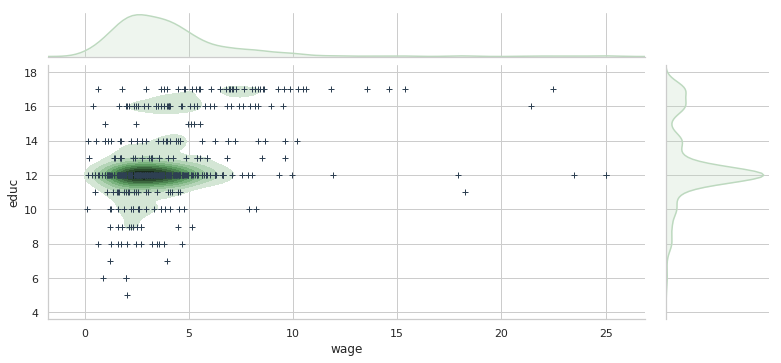

In [18]:
g = sns.jointplot(x="wage", y="educ", data=df, kind="kde", color="#bdd9bf")
g.plot_joint(plt.scatter, c="#2e4052", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('wage', 'educ')
plt.gcf().set_size_inches(12, 5)
plt.show()

__Comment__ : We noticed that the higher the years of education is, the bigger the range of salary becomes. Meaning that with a high education, the probability to have a higher salary increases. We also noticed a huge density of people for 12 years of education, which correspond to the end of primary and secondary school. Therefore, everything above 12 years correspond to college or university. 

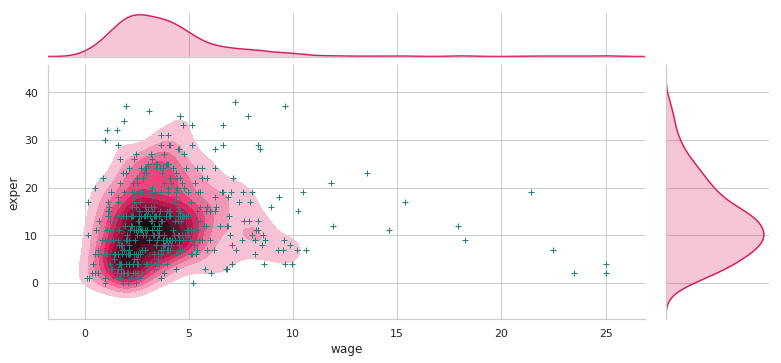

In [19]:
g = sns.jointplot(x="wage", y="exper", data=df, kind="kde", color="#d81e5b")
g.plot_joint(plt.scatter, c="#218380", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('wage', 'exper')
plt.gcf().set_size_inches(12, 5)
plt.show()

__Comment__ : We noticed that the data are concentrated around one point, however, the range of wage does not seems to increase with experience. The most surprising is that the outliers (women with high salary) tends to have the less experience  and do not seems to see women with high experience and high salary. We could put several guess on why is that ? Maybe those woman retired early, maybe they stop working because their husband have high salary as well..  


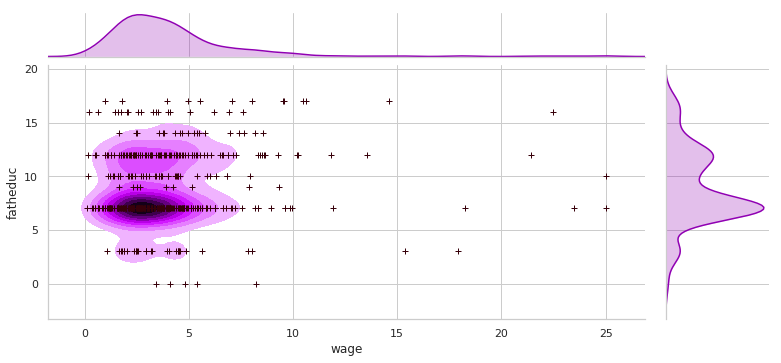

In [20]:
g = sns.jointplot(x="wage", y="fatheduc", data=df, kind="kde", color="#9000b3")
g.plot_joint(plt.scatter, c="#37000a", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('wage', 'fatheduc')
plt.gcf().set_size_inches(12, 5)
plt.show()

__Comment__ : Based on this graph, it does not seems to be a correlation between the education years of the father and the salary. Indeed the range of salary does not seems to variate with the fatheduc variable. 

### Biased estimators principle

The fondamental hypothesis which ensure to have non biased estimators is the no-correlation between variables and the residuals. Let's try to summarize why : 

we have : $Y_i = X_i\beta + \epsilon_i$ where $\epsilon$ is the residuals. In OLS, we estimate $\beta$ via $\hat \beta$

<center>$
\hat \beta = (X^TX)^{-1}X^TY \\
\hat \beta = (X^TX)^{-1}X^T(X_i\beta + \epsilon_i)\\
\hat \beta = \beta + (X^TX)^{-1}X^T \epsilon_i \\
\mathbb{E}(\hat\beta|X) = \mathbb{E}(\beta|X) + \mathbb{E}((X^TX)^{-1}X^T \epsilon|X) \\
\mathbb{E}(\hat\beta|X) = \mathbb{E}(\beta|X) + \mathbb{E}((X^TX)^{-1}X^T \epsilon|X) \\
\mathbb{E}(\hat\beta|X) = \beta +  (X^TX)^{-1}X^T \mathbb{E}(\epsilon|X) \\
\mathbb{E}(\hat\beta|X) = \beta + biais
$</center>


Therefore, we see that if $\mathbb{E}(\epsilon|X) \neq 0 $ , we have a biais in the estimator $\hat \beta$ 

### First regression of wage
We regress wage using the explanatory variables a constant, city, educ, exper, nwifeinc, kidslt6, kidsgt6.

In [21]:
n,k = df.shape
X_wage = np.c_[np.ones((n,1)), df[['city', 'educ','exper', 'nwifeinc', 'kidslt6', 'kidsge6']].values]
y_wage = df["wage"]

In [22]:
beta_wage, u_wage, sig2_wage, std_wage, t_wage, SSR_wage, p_value_wage = compute_pvalue_stat(X_wage,y_wage,X_wage.shape[1])

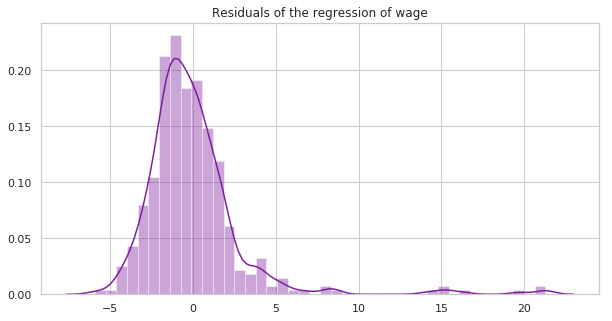

In [23]:
res_wage = pd.DataFrame(u_wage)
plt.figure(figsize =(10,5))
sns.distplot(res_wage, color  = sns.xkcd_rgb["purple"])
plt.title("Residuals of the regression of wage")
plt.show()

The residuals does not seems to follow a normal law since we got a tail distribution. It might be a bad idea to use this model since the residuals does not seems to follow a normal law

### Second regression with log(wage)
We do the lwage regression on a constant, city, educ, exper, nwifeinc, kidslt6, kidsgt6. We compare it to the previous regression.

In [24]:
y_lwage = df["lwage"]
beta_lwage, u_lwage, sig2_lwage, std_lwage, t_lwage, SSR_lwage, p_value_lwage = compute_pvalue_stat(X_wage,y_lwage,X_wage.shape[1])

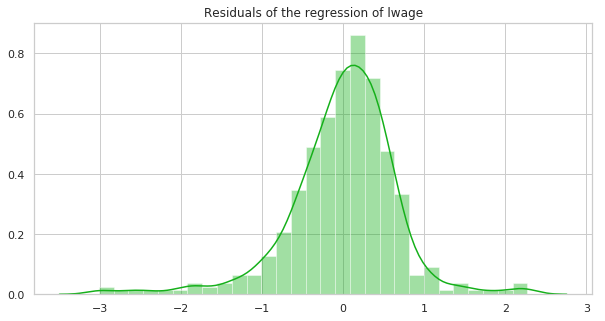

In [25]:
res_lwage = pd.DataFrame(u_lwage)
plt.figure(figsize =(10,5))
sns.distplot(res_lwage,  color  = sns.xkcd_rgb["green"])
plt.title("Residuals of the regression of lwage")
plt.show()

The log residuals seems is closer of a normal distribution than the wage residuals. The logarithm allows to smooth the outliers and therefore, the log modelisation seeems to be  a better fit for the regression. 

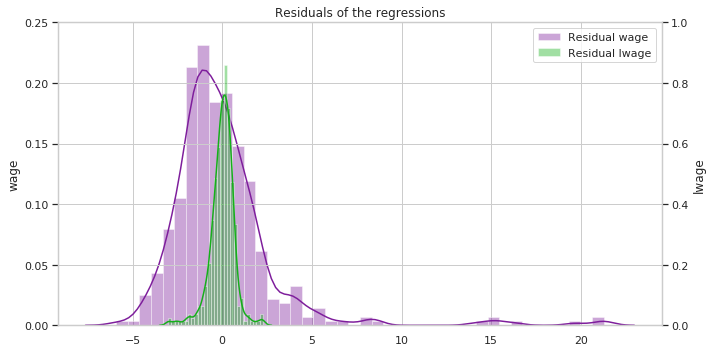

In [26]:
res_wage = pd.DataFrame(u_wage)
fig, ax1 = plt.subplots(figsize = (10,5))

# Create grid wit share x
ax1.set_ylabel("wage")
ax2 = ax1.twinx()
ax2.set_ylabel("lwage")


lns1= sns.distplot(res_wage, label='Residual wage', ax = ax1, color  = sns.xkcd_rgb["purple"])
lns2 = sns.distplot(res_lwage, label='Residual lwage', ax = ax2, color  = sns.xkcd_rgb["green"])
plt.title("Residuals of the regressions")

# Set legend
lns1, lab1 = ax1.get_legend_handles_labels()
lns2, lab2 = ax2.get_legend_handles_labels()
ax2.legend(lns1+lns2,lab1+lab2)

# set the ticks
ax1.set_yticks(np.arange(0,0.3,0.05))
ax2.set_yticks(np.arange(0,1.2,0.2))

plt.tight_layout()
plt.show()

__Comment__ : Looking at those two graphs, we see that our second regression (lwage) is closer to a normal law than the our first regression (wage)

### Singnificativity of results
We test the hypothesis of non-significance of the experiment with a significance threshold of 1%, 5% and 10% (alternative test on both sides)

Our custom function 'compute_pvalue_stat' already calculate the p-value for the significance test for each variables.Therefore, we will just take the corresponding value. I assume that we are doing this test on the __logarithm regression__.

We will test that the hypothesis $H_0 = [ \beta_{exper}  = 0]$ (aka significance test)

In [30]:
print("The value of Beta for the educ variable in the lwage regression is {:.4f}".format(beta_lwage[3]))
print("The p-value for the exper significance test in the lwage regression is : {:.5f}".format(p_value_lwage[3]))

The value of Beta for the educ variable in the lwage regression is 0.0155
The p-value for the exper significance test in the lwage regression is : 0.00061


We reject the hypothesis $H_0$ (significance test) with a risk of 1 %. Therefore, Experience does have signicance in the model

### Hypothesis testing : coefficient of educ 10% 
We test the hypothesis that the coefficient associated with educ is equal to 10% with a significance threshold of 5% (alternative test on both sides)

We will test that the hypothesis $H_0 = [ \beta_{educ}  = 0.1]$

In [31]:
# let's create a new statistic of test
t_H0 = (beta_lwage[2]-0.1)/std_lwage[2]
p_distrib_H0 = stats.t.cdf(abs(t_H0) , df=n-(X_wage.shape[1])) 
p_value_H0 = (1 - p_distrib_H0) * 2
print("The value of Beta for the educ variable in the lwage regression is {:.4f}".format(beta_lwage[2]))
print("The p-value for the test H0 is {:.2f}".format(p_value_H0))

The value of Beta for the educ variable in the lwage regression is 0.1022
The p-value for the test H0 is 0.88


We accept the hypothesis $H_0$.

### Hypothesis testing : education yield is 10%
Tester l’hypothèse jointe que le rendement de l’éducation est de 10% et que celui de l’expérience professionnelle est de 5%.

We will test that the hypothesis $H_0 = [ \beta_{educ}  = 0.1 \, \& \, \beta_{exper}  = 0.05]$

Since we are trying to test multiple restrictions at once, we need to use the F-test. Indeed, using individuals p-value test (i.e. testing the each hypothesis individually) will not  lead to a correct answer because the t-statistic test put no restrictions on the other parameters. 

We calculated the following __unrestricted__ model
<center> $Lwage = \beta_0 + \beta_1x_{city} + \beta_2x_{educ} +  \beta_3x_{exper} + \beta_4x_{nwifeinc}+ \beta_5x_{kidslt6}+ \beta_6x_{kidsge6}$ </center>

Let's put the following __restricted__ model (according to $H_0$) : 
<center>$Lwage - 0.1x_{educ} -  0.05x_{exper} = \hat y =   \beta_0 + \beta_1x_{city} +  \beta_4x_{nwifeinc}+ \beta_5x_{kidslt6}+ \beta_6x_{kidsge6}$</center>

We will calculate the following F-statistics : 

<center>$F = \frac{SSR_r - SSR_{ur}}{SSR_{ur}}* \frac{n-k}{q} $</center>

with k = 7 (number of parameters in unrestricted including intercept)
and q = 2 (number of restricted parameters)

In [32]:
# t_H0 = (beta_lwage[2]-0.1+ beta_lwage[3]-0.05)/(std_lwage[2]  + std_lwage[3])

# SSR unrestricted
SSR_ur = SSR_lwage

# Restricted model
y_res = df["lwage"] - 0.1*df["educ"] - 0.05*df["exper"] 
X_res = np.c_[np.ones((df.shape[0],1)), df[['city', 'nwifeinc', 'kidslt6', 'kidsge6']].values]
beta_res, _, _, _, _, SSR_res, _ = compute_pvalue_stat(X_res,y_res,X_res.shape[1])

In [33]:
F = (SSR_res - SSR_ur)/SSR_ur * (n-7/2)
p_val = 1 - stats.f.cdf(F,n-7,2)
print('The Beta value for education in the unrestricted model is {:.3f}'.format(beta_lwage[2]))
print('The Beta value for education in the unrestricted model is {:.3f}'.format(beta_lwage[3]))
print('The p_value for our F statistic test is {:.3f}'.format(p_val))

The Beta value for education in the unrestricted model is 0.102
The Beta value for education in the unrestricted model is 0.015
The p_value for our F statistic test is 0.017


We reject the hypothesis $H_0$ with a risk of 5 %. Since we hypothesis $\beta_{educ}  = 0.1$, we can assume that the issue comes from the part $\beta_{exper}  = 0.05$

### Salary augmentation with experience

We want to calculate the increase in percentage for 10 years of experience. We will based our calculation on the logarithm regression model. 

Based on this model, we have : 
<center>
$lwage_{t+10} = lwage_t + 10*\beta_{exper}\\
wage_{t} = \exp(lwage_{t}) \\
wage_{t+10} = \exp(lwage_{t+10}) = \exp( lwage_t + 10*\beta_{exper}) \\
wage_{t+10} = \exp( lwage_t) * \exp( 10*\beta_{exper})\\$
    
    
Therefore, the increase percentage is : $
\frac{wage_{t+10}-wage_{t}}{wage_{t}}= \exp( 10*\beta_{exper}) - 1 
$
    </center>

In [34]:
print("With 10 years of experience, the increase in salary is {:.2f} %".format(100*(np.exp(10*beta_lwage[3])-1)))

With 10 years of experience, the increase in salary is 16.75 %


### Comparison of coefficient for kids greater or lower than 6

We are trying to define if $\beta_{5}  = \beta_{6}$ inside the model : \


<center> $Lwage = \beta_0 + \beta_1x_{city} + \beta_2x_{educ} +  \beta_3x_{exper} + \beta_4x_{nwifeinc}+ \beta_5x_{kidslt6}+ \beta_6x_{kidsge6}$ </center>

Let's put $\theta_1 =  \beta_{5}  - \beta_{6}$, if we replace this in the previous model, we obtain the new model : 

<center> $Lwage = \beta_0 + \beta_1x_{city} + \beta_2x_{educ} +  \beta_3x_{exper} + \beta_4x_{nwifeinc}+ (\theta_1 + \beta_6)x_{kidslt6}+ \beta_6x_{kidsge6}\\
Lwage = \beta_0 + \beta_1x_{city} + \beta_2x_{educ} +  \beta_3x_{exper} + \beta_4x_{nwifeinc}+ \theta_1x_{kidslt6}+ \beta_6(x_{kidsge6} + x_{kidslt6})$ </center>

Therefore, in this model, are new hypothesis become $H_0 = [ \beta_{5}  = \beta_{6}] = [\theta_1 =0]$

Let's define the new variable $x_{kids} = x_{kidsge6} + x_{kidslt6}$ and define this new model

In [36]:
# New dataset with the new variable
df_kid= df.copy()
df_kid["kids"] = df_kid["kidsge6"] + df_kid["kidslt6"]

y_kid = df_kid["lwage"]
X_kid = np.c_[np.ones((df_kid.shape[0],1)), df_kid[['city', 'educ','exper', 'nwifeinc', 'kidslt6', 'kids']].values]
beta_kid, _, _, _, _, SSR_kid, p_val_kid = compute_pvalue_stat(X_kid,y_kid,X_kid.shape[1])

print("The value of Beta for the kidslt6 variable in the lwage_kid regression is {:.4f}".format(beta_kid[5]))
print("The value of Beta for the kids variable in the lwage_kid regression is {:.4f}".format(beta_kid[6]))
print("The p-value for the test H0 is {:.4f}".format(p_val_kid[5]))

The value of Beta for the kidslt6 variable in the lwage_kid regression is -0.0336
The value of Beta for the kids variable in the lwage_kid regression is -0.0117
The p-value for the test H0 is 0.7103


We accept the hypothesis $H_0$. Therefore, we accept the hypothesis $ \beta_{5}  = \beta_{6}$

### Structural change on 3 class of age woman
We test the structural change between women under 30 years of age, between 30 and 43 years of age, over 43 years of age (3 mutually exclusive groups)

The goal of this part is to test if the coefficient of the regression are stable accros 3 groups. 

To test this hypothesis, we will do a chow test on the 3 groups.

We define the unrestricted model as : 

$Lwage = \beta_{0,0} + \beta_{1,0}x_{city} + \beta_{2,0}x_{educ} +  \beta_{3,0}x_{exper} + \beta_{4,0}x_{nwifeinc}+ \beta_{5,0}x_{kidslt6}+ \beta_{6,0}x_{kidsge6}$ : Regression on $x_{age} \leq 30$ 

$Lwage = \beta_{0,1} + \beta_{1,1}x_{city} + \beta_{2,1}x_{educ} +  \beta_{3,1}x_{exper} + \beta_{4,1}x_{nwifeinc}+ \beta_{5,1}x_{kidslt6}+ \beta_{6,1}x_{kidsge6}$ : Regression on $30 < x_{age} \leq 43$

$Lwage = \beta_{0,2} + \beta_{1,2}x_{city} + \beta_{2,2}x_{educ} +  \beta_{3,2}x_{exper} + \beta_{4,2}x_{nwifeinc}+ \beta_{5,2}x_{kidslt6}+ \beta_{6,2}x_{kidsge6}$ : Regression on $43 < x_{age}$

Then $SSR_{unr} = SSR_1 + SSR_2+ SSR_3$ 

We define the restricted model as : 

$Lwage = \beta_{0} + \beta_{1}x_{city} + \beta_{2}x_{educ} +  \beta_{3}x_{exper} + \beta_{4}x_{nwifeinc}+ \beta_{5}x_{kidslt6}+ \beta_{6}x_{kidsge6}$ : for all age

Let's caculate the SSR for both model

In [37]:
df_plus43 = df[df["age"] > 43]
df_entre3043 = df[ (df["age"] <= 43) & ( df["age"] > 30)]
df_moins30 = df[df["age"] <= 30]

X_plus43 = np.c_[np.ones((df_plus43.shape[0],1)), df_plus43[['city', 'educ','exper', 'nwifeinc', 'kidslt6', 'kidsge6']].values]
y_plus43 = df_plus43["lwage"]
beta_plus43, u_plus43, sig2_plus43, std_plus43, t_plus43, SSR_plus43, p_value_plus43 = compute_pvalue_stat(X_plus43,y_plus43,X_plus43.shape[1])

X_entre3043 = np.c_[np.ones((df_entre3043.shape[0],1)), df_entre3043[['city', 'educ','exper', 'nwifeinc', 'kidslt6', 'kidsge6']].values]
y_entre3043 = df_entre3043["lwage"]
beta_entre3043, u_entre3043, sig2_entre3043, std_entre3043, t_entre3043, SSR_entre3043, p_value_pentre3043 = compute_pvalue_stat(X_entre3043,y_entre3043,X_entre3043.shape[1])

X_moins30 = np.c_[np.ones((df_moins30.shape[0],1)), df_moins30[['city', 'educ','exper', 'nwifeinc', 'kidslt6', 'kidsge6']].values]
y_moins30 = df_moins30["lwage"]
beta_moins30, u_moins30, sig2_moins30, std_moins30, t_moins30, SSR_moins30, p_value_moins30 = compute_pvalue_stat(X_moins30,y_moins30,X_moins30.shape[1])

Let's calculate the chow statistic : 
$F = \frac{SSR_r - (SSR_1+SSR_2+SSR_3)}{(SSR_1+SSR_2+SSR_3)} * \frac{n-k_{unr}}{q}$

In this case : 
- n = 428 : number of samples
- $k_{unr} = 3*7 = 21 $ because with have 7 variables (including intercepts) in 3 models. 
- q = 14 because we have 2 less variables in the restricted intercept.


In [38]:
SSR_r = SSR_lwage # Calculated previously 
SSR_1 = SSR_moins30
SSR_2 = SSR_entre3043
SSR_3 = SSR_plus43

F = (SSR_r - SSR_1 - SSR_2 - SSR_3) / (SSR_1+SSR_2+SSR_3) * (428-21)/14
p_val = 1- stats.f.cdf(F, 14, 428-21)
print('The Beta factors for intervals 1 are : {}'.format(beta_moins30))
print('The Beta factors for intervals 2 are : {}'.format(beta_entre3043))
print('The Beta factors for intervals 3 are : {}'.format(beta_plus43))
print('The Beta factors for the restricted model are : {}'.format(beta_lwage))
print('The p_value for our F statistic test is {:.3f}'.format(p_val))

The Beta factors for intervals 1 are : [-2.11133116 -0.19463453  0.22197271  0.05210503  0.01609718 -0.20868983
  0.0898007 ]
The Beta factors for intervals 2 are : [-0.52452336  0.08895     0.11162652  0.0210642   0.00284034 -0.08924667
 -0.01352149]
The Beta factors for intervals 3 are : [-0.32320059 -0.01884044  0.0852654   0.01783745  0.00926955 -0.00912318
 -0.02488311]
The Beta factors for the restricted model are : [-0.39897523  0.03526789  0.10224755  0.01548787  0.0048827  -0.04530287
 -0.01170351]
The p_value for our F statistic test is 0.872


Therefore, the structure is slable among the 3 sub-groups

### Importance of having a child younger than 6 year old
From the kidslt6 variable, we create a set of binary variables for the number of children under 6 years old. We use as a reference women with children over 6 years of age

In [39]:
# Evaluate the range of Kidsge6 in the dataset
print("The max number of kids lower than 6 years is {}".format(np.max(df["kidslt6"].values)))

The max number of kids lower than 6 years is 2


Let's create 2 new binary columns "1kidslt6" and "2kidslt6" 

In [41]:
# Creation of the binary variables
df["1kidslt6"] = 0
df["2kidslt6"] = 0
df.loc[df["kidslt6"] == 1, '1kidslt6'] = 1
df.loc[df["kidslt6"] == 2, '2kidslt6'] = 1

In [42]:
df[["kidslt6","1kidslt6","2kidslt6"]].head(10)

,kidslt6,1kidslt6,2kidslt6
0,1,1,0
1,0,0,0
2,1,1,0
3,0,0,0
4,1,1,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,0


__Question__ : The categories kidsge6 > 0 and kidsge == 0 are two groups mutually exclusif in our scenario because the data are not time series, they  reprends the situation at a single time. Thereefore, for a given time, we either have a kids which are 6 years old or more, or we don't.   

In [43]:
df_kidsge6 = df[df["kidsge6"] > 0]
df_nokidsge6 = df[df["kidsge6"] == 0]

X_kidsge6 = np.c_[np.ones((df_kidsge6.shape[0],1)), df_kidsge6[['city', 'educ','exper', 'nwifeinc', '1kidslt6', '2kidslt6']].values]
y_kidsge6 = df_kidsge6["lwage"]
beta_kidsge6, _, _, _, _, SSR_kidsge6, _ = compute_pvalue_stat(X_kidsge6,y_kidsge6,X_kidsge6.shape[1])

X_nokidsge6 = np.c_[np.ones((df_nokidsge6.shape[0],1)), df_nokidsge6[['city', 'educ','exper', 'nwifeinc', '1kidslt6', '2kidslt6']].values]
y_nokidsge6 = df_nokidsge6["lwage"]
beta_nokidsge6,_ , _, _, _, SSR_nokidsge6, _ = compute_pvalue_stat(X_nokidsge6,y_nokidsge6,X_nokidsge6.shape[1])

Let's do a test of significance (Granger causality test) for the variables "1kidslt6" and "2kidslt6" in both group

In [46]:
# Test for women with kidsge6 > 0 

# Restricted model via removing 1kidslt6 and 2kidslt6 variables
X_kidsge6_rest = np.c_[np.ones((df_kidsge6.shape[0],1)), df_kidsge6[['city', 'educ','exper', 'nwifeinc']].values]
beta_kidsge6_rest, _, _, _, _, SSR_kidsge6_rest, _ = compute_pvalue_stat(X_kidsge6_rest,y_kidsge6,X_kidsge6_rest.shape[1])

# F statistics score with the according p_value
n_kidsge6 = df_kidsge6.shape[0]
F_kidsge6 = (SSR_kidsge6_rest - SSR_kidsge6) / (SSR_kidsge6) * (n_kidsge6-7)/2
p_kidsge6 = 1 - stats.f.cdf(F_kidsge6, 2, n_kidsge6-7)
print('The p_value for our F statistic test is {:.4f}'.format(p_kidsge6))

The p_value for our F statistic test is 0.7172


In [47]:
# Test for women with kidsge6 == 0 

# Restricted model via removing 1kidslt6 and 2kidslt6 variables
X_nokidsge6_rest = np.c_[np.ones((df_nokidsge6.shape[0],1)), df_nokidsge6[['city',"educ","exper","nwifeinc"]].values]
beta_nokidsge6_rest, _, _, _, _, SSR_nokidsge6_rest, _ = compute_pvalue_stat(X_nokidsge6_rest,y_nokidsge6,X_nokidsge6_rest.shape[1])

# F statistics score with the according p_value
n_nokidsge6 = df_nokidsge6.shape[0]
F_nokidsge6 = (SSR_nokidsge6_rest - SSR_nokidsge6) / (SSR_nokidsge6) * (n_nokidsge6-7)/2
p_nokidsge6 = 1 - stats.f.cdf(F_nokidsge6, 2, n_nokidsge6-7)
print('The p_value for our F statistic test is {:.4f}'.format(p_nokidsge6))

The p_value for our F statistic test is 0.7894


__observation__ Therefore for both groups, the binaries variables are not signiciant, therefore, having either 1 or 2 kids below 6 years is insignificant to the model. Moreover, since we prove tht the coeefficient for kids below or over 6 years are the same, we could strongly suggets that having kids over 6 years old are not significant as well on the model. 

__Explanation__ 

How can we explain this ? Our suggestion is that the dataset is biaised and the women cpatured by it are the ones slighly impacted (for the salary) by having kids. 

What is our reasoning ? Since this dataset is from 1975, we can easily assume that at this period, when a couple have kids, they either have the money to pay for a nappy or either one of the parents stop working to take care of the kids ,in which case, if it is the mother, she will not be in the dataset because we filtered the negative wage, corresponding to the women which wre not working. We can double check this by looking at the inlf value. 
Therefore, in both ways, the women either keep working and her salary is not impacted byhaving kids, or either she stopped working and she is not registered in the dataset. That is why we believed the dataset is biased. 

### Regression of inlf
From the overall sample, we regress inlf to a constant, city, educ, age, kidslt6, kidsgt6

In [75]:
# reload the dataset since we drop the negative wage (which contains the inlf == 0 )

df = pd.read_csv('Data/MROZ.raw', sep='\s+', header= None )
df = df.rename(columns={0: 'inlf', 1: 'hours', 2: 'kidslt6', 3: 'kidsge6', 4: 'age', 5: 'educ', 6: 'wage',
                        7: 'repwage', 8: 'hushrs', 9: 'husage', 10: 'huseduc', 11: 'huswage', 12: 'faminc',
                        13: 'mtr', 14: 'motheduc', 15: 'fatheduc', 16: 'unem', 17: 'city', 18: 'exper',
                        19: 'nwifeinc', 20: 'lwage', 21: 'expersq'})

df['wage'].replace(to_replace='.', value=0, inplace=True)
df['lwage'].replace(to_replace='.', value=0, inplace=True)

# Convert the field type for 'wage' & 'lwage'
df['wage']= pd.to_numeric(df['wage'])
df['lwage']= pd.to_numeric(df['lwage'])

In [88]:
X_inlf = np.c_[np.ones((df.shape[0],1)), df[['city', 'educ','age', 'kidslt6', 'kidsge6']].values]
y_inlf = df["inlf"]
beta_inlf, _, _, std_inlf, t_inlf, SSR_inlf, p_value_inlf = compute_pvalue_stat(X_inlf,y_inlf,X_inlf.shape[1])

df_results = pd.DataFrame( index = ["Intercept","city", 'educ','age', 'kidslt6', 'kidsge6'],
                          columns = ["beta", "p_value"])
df_results["beta"] = beta_inlf
df_results["p_value"] = np.round(p_value_inlf,3)
df_results.head(6)

,beta,p_value
Intercept,0.707578,0.000
city,-0.034085,0.346
educ,0.043410,0.000
age,-0.013026,0.000
kidslt6,-0.307467,0.000
kidsge6,-0.017341,0.219


__Comment1__ 

Based on the results, almost all the factors are important to determine if somebody is in the labour force or not. Taking individually, the city does not seems to have an impact on the values (it has a p_value superior at 34%).
At this period, living in the city might not have much impact on the finding a job or not, we can assume it was not "centralize" at is it today. Or maybe those women where living in suburbs and could drive to work. (if we assume that suburbs is not in the city)

__Comment2__

Another interesting information is the p_value for kidslt6 and kisge6. It seems, based on those variables that having kids greater than 6 have no impact on working or not which is not true for kidslt6. We should read this carefully, since they are is a strong correlation and cause-consequence relationship between those two variables. However, we can assume than having kids greater than 6 years old has no impact on being part of the labour force, because the kids are more independent, required less care and therefore, the woman (if she had stopped working for the kids) couldgo back to work if she wants. 

### Probit model of inlf
We estimate the probit model of inlf on a constant, city, educ, age, kidslt6, kidsgt6. Then test the non-significance attached to the coefficients associated with kidslt6 and kidsgt6. We then compare the test result with the previous results.

For this part, we will use the library statsmodels to comput the probit calculation

In [106]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit

In [102]:
y_pro = df["inlf"]
X_pro = sm.add_constant(df[["city","educ", "age", "kidslt6", "kidsge6"]])
model_probit = Probit(y_pro,X_pro).fit()
model_probit.summary()

Optimization terminated successfully.
         Current function value: 0.617205
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                   inlf   No. Observations:                  753
Model:                         Probit   Df Residuals:                      747
Method:                           MLE   Df Model:                            5
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                 0.09734
Time:                        13:05:22   Log-Likelihood:                -464.76
converged:                       True   LL-Null:                       -514.87
                                        LLR p-value:                 4.714e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6050      0.467      1.297      0.195      -0.309       1.520
city          -0.0863      0.102     -0.842      0.400      -0.287       0.115
educ           0.1234      0.023      5.469      0.000       0.079       0.168
age           -0.0375      0.007     -5.008      0.000      -0.052      -0.023
kidslt6       -0.8846      0.112     -7.882      0.000      -1.105      -0.665
kidsge6       -0.0542      0.040     -1.351      0.177      -0.133       0.024
==============================================================================
"""

__Comment__ 

We see similar conclusions regarding the p_values, city and kids greater than 6 years (taken individually) does not seems to have an significance on the dataset. 


However, the Probit regression had an impact on the intercept coefficient and its p_values, which is normal since the probit regression is mroe fit in this scenario (since it is a logistic regression). In the previous regression, the intercept was made to balance (as much as possible) the data close to 0 and 1, which is not required here.  

### Partial effect computation
We compute the partial effects for all the explanatory variables: $\partial p(y=1)/\partial x_k $ for (k = 1, ...,K), where K is the number of explanatory variables

In [98]:
beta_pro = model_probit.params.values
Xb_pro = X_pro@beta_pro
partial_pro = np.mean(scipy.stats.norm.pdf(Xb_pro))*beta_pro

In [101]:
df_part_pro = pd.DataFrame( index = ["city", 'educ','age', 'kidslt6', 'kidsge6'],
                          columns = ["partial effect"])
df_part_pro["partial effect"] = partial_pro[1:]
df_part_pro.head(6)

,partial effect
city,-0.030407
educ,0.043471
age,-0.013225
kidslt6,-0.311638
kidsge6,-0.019105


__Comment__ 

In a strange  way, the partial effect calculated from the probit are really closed of the beta (and in the linear regression model, also the partial effect) calculated previously.
Therefore, even if the probit regression is better fit for the binary problem, doing a linear regression can already give us a decent approximation of the partial effect of the probit regression. This similaritude  is probably only correct for small partial effect. 

### Non significativity test with likelihood
Test the attached non-significance of the coefficients associated with kidslt6 and kidsgt6 using the likelihood ratio method

In [110]:
# Loglikehood of un-restrained model 
Llik_unr = model_probit.llf

# Define the constrained model without kislt6 and kidsgt6
X_pro_rest = sm.add_constant(df[["city","educ", "age"]])
model_probit_rest = Probit(y_pro,X_pro_rest).fit()
Llik_rest=model_probit_rest.llf

# Calculation of the p-values via the likelihood ratio
Ratio_Llik=2*(Llik_unr-Llik_rest)
p_vals_Llik = 1-chi2.cdf(Ratio_Llik,2)
print("The p_values for our log likehood ration test is {}".format(p_vals_Llik))

Optimization terminated successfully.
         Current function value: 0.663577
         Iterations 4
The p_values for our log likehood ration test is 6.661338147750939e-16


We can reject the hypothesis of non-significance with a risk at 1 % for the coefficients Kidslt6 and Kidsgt6. It is in coherent with the value computed before where we saw the p-values for the kidslt6 was significant. 

## Time Series

### Reading the file

In [3]:
df = pd.read_excel('Data/quarterly.xls', sep='\s+', index_col='DATE', parse_dates=True)
df.index = df.index.to_period("Q")
df.head(10)

,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
DATE,,,,,,,,,,,,,,,,,,
1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073
1961Q2,1.73,2.30,2.94,3.62,3.79,31.47,33.33,29.83,19.23,141.40,966.4,320.97,7.00,23.00,2869.6,2962.9,18.785,32.131
1961Q3,1.68,2.30,3.01,3.90,3.98,31.50,33.33,29.95,19.32,142.00,982.7,326.50,6.77,23.74,2915.9,2991.3,18.843,32.699
1961Q4,2.40,2.46,3.10,3.84,3.97,31.53,33.37,29.99,19.37,146.63,1000.0,334.70,6.20,24.57,2975.3,3019.9,18.908,33.421
1962Q1,2.46,2.72,3.21,3.84,4.02,31.70,33.53,30.11,19.44,146.37,1020.7,341.17,5.63,24.94,3028.7,3048.7,19.020,33.136


In [4]:
print('Is there null values:', df.isnull().values.any())
print('Is there na values:', df.isna().values.any())

Is there null values: False
Is there na values: False


### Computation of inflation
Calculate inf, the inflation rate from the CPI variable. Make a graph in the time of inf

In [5]:
df['Inf'] = ((df.CPI-df.CPI.shift())/(df.CPI.shift()))*100

In [6]:
df[['CPI',"Inf"]].head()

,CPI,Inf
DATE,,
1960Q1,29.40,NaN
1960Q2,29.57,0.578231
1960Q3,29.59,0.067636
1960Q4,29.78,0.642109
1961Q1,29.84,0.201478


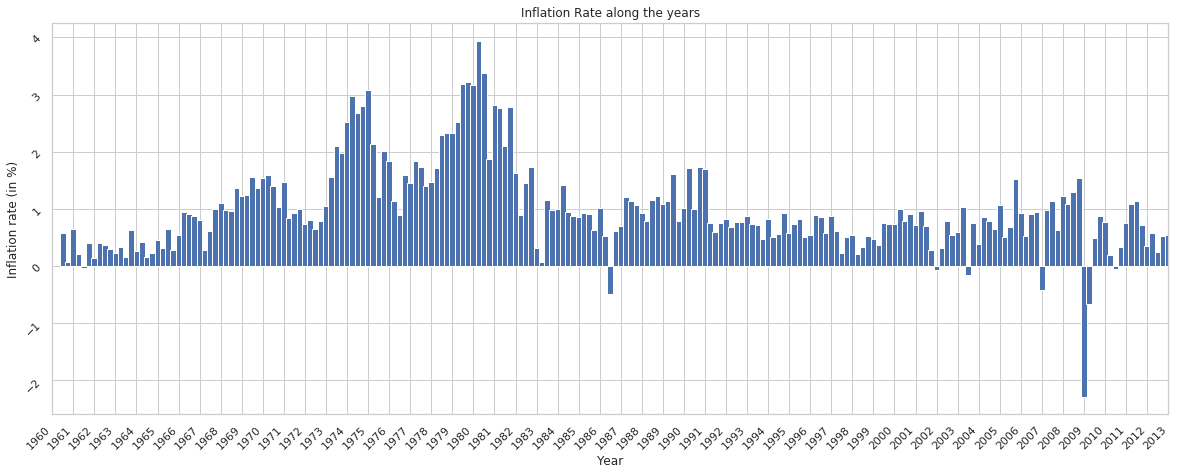

In [7]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator((1,4,7,10))  # every month
yearsFmt = mdates.DateFormatter('%Y')

# Load a numpy record array from yahoo csv data with fields date, open, close,
# volume, adj_close from the mpl-data/example directory. The record array
# stores the date as an np.datetime64 with a day unit ('D') in the date column.

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df.index.values.astype('datetime64[D]'),df['Inf'].values, width = 100)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemin = np.datetime64(df.index.values.astype('datetime64[D]')[0], 'Y')
datemax = np.datetime64(df.index.values.astype('datetime64[D]')[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
ax.tick_params(labelrotation=45)
plt.title("Inflation Rate along the years")
plt.xlabel('Year')
plt.ylabel("Inflation rate (in %)")
plt.show()

__Comment__ 

it seems  the inflation is not stationnary and the veriance seems to not be equal accros the dataset.

### autocorrelogram
We interpret the autocorrelogram and partial autocorrelograms of inf

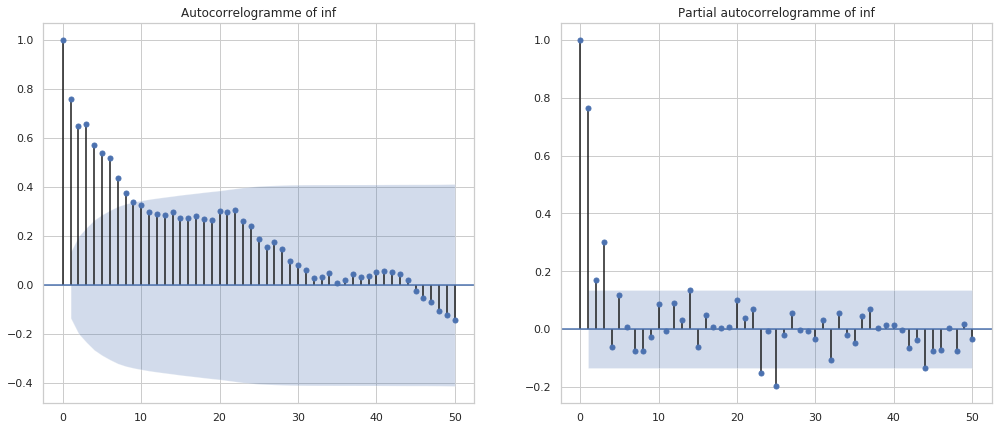

In [8]:
# import statsmodels.api as sm
fig, axes = plt.subplots(1, 2, figsize=(17,7))
fig = plot_acf(df['Inf'].values[1:],ax=axes[0], lags = 50)
axes[0].set_title("Autocorrelogramme of inf")
fig = plot_pacf(df['Inf'].values[1:], ax=axes[1], lags = 50)
axes[1].set_title("Partial autocorrelogramme of inf")
plt.show()

__Difference between ACF and PACF__ 

Given a timeseries $(Z_t)_{t=1..n}$, ACF calculates the correlation between $(Z_t)$ and $(Z_{t-k})$. Therefore, the graph that we see on the left correspond to the $Corr(Z_t, Z_{t-k})$

However, if $\rho_1 = Corr(Z_t,Z_{t-1})$ then , we can also said that $\rho_1 = Corr(Z_{t-1},Z_{t-2})$. Therefore $\rho_2 = Corr(Z_t,Z_{t-1})$ will be affected (or included at some extent) $\rho_1$. We can extend this issue effect for all the lags. 

The PACF calculate the "pure" correlation between $Z_t$ and $Z_{t-k}$, by removing the "transitive" correlation ($\rho_1, \rho_2, etc.. $). 

__Comment__ 
Those two graph give a perfect example of the difference between ACF and PACF. 
Indeed, with the ACF, we see a that a correlation keep until  the the lags k =8. 
However, the partial correlation show that most of the "pure" correlation can be found in until the lags k =3.

Therefore the correlation we see in the ACF graph between lags k=4 & k=8 is mostly due to transitive correlation.

We can suppose, if we plan to do a AR model, that most of the information will be held in $Inf_{t-1}$, $Inf_{t-2}$ and $Inf_{t-3}$

### Stationnarity and ergodicity

A process is said "ergodic" when the initial condition does not influence the inference

A process is said "stationary" if $f(Z_1,Z_2,..,Z_t)$ and $f(Z_{1+k},Z_{2+k},..,Z_{t+k})$ follows the same law. We talk of weak stationarity when the mean and variance is finite and constant through time but also when the autocorellation between Zt and ZT-k does not depend of the time shift.

We need ergodicity and stationarity (and finite variance) to make inference using the data

"spurious regression" is the situation were we use the properties of a stationary serie on a non stationary one. It gives fake results, often too optimistic and can make think of correlation between variables when there is none.

### AR modelisation

In [9]:
list_bic = []
list_aic = []
lag = 40

for i in range(0, lag):
    res = sm.tsa.ar_model.AR(df['Inf'][1:]).fit(i)
    list_aic.append(res.aic)
    list_bic.append(res.bic)

min_degree_aic = list_aic.index(min(list_aic))
min_degree_bic = list_bic.index(min(list_bic))
degree =  min([min_degree_aic, min_degree_bic])
print('Degree minimum for bic: ', min_degree_bic)
print('Degree minimum for aic: ', min_degree_aic)
print('Degree selected: ', degree, ', method:', 'bic' if min_degree_bic < min_degree_aic else 'aic')


Degree minimum for bic:  3
Degree minimum for aic:  3
Degree selected:  3 , method: aic


### Philips curve
We estimate the Philips curve model that explains the unemployment rate (Unemp) as a function of the current inflation rate and a constant.

In [10]:
from sklearn.linear_model import LinearRegression
X = df["Inf"].values[1:].reshape(-1,1)
y = df["Unemp"].shift().values[1:]
reg = LinearRegression().fit(X, y)
predict_unemp = reg.predict(X)

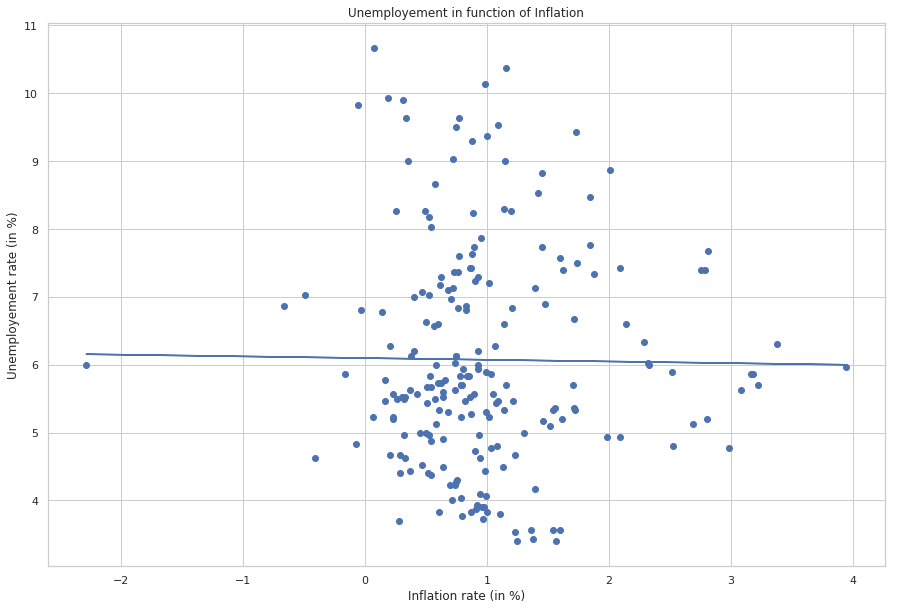

Intercept value : 6.098
Beta (Inflation) value : -0.02488


In [11]:
# Plot Phillips 
plt.figure(figsize = (15,10))
plt.scatter(X, y)
plt.plot(X, predict_unemp)
plt.ylabel("Unemployement rate (in %)")
plt.xlabel("Inflation rate (in %)")
plt.title("Unemployement in function of Inflation")
plt.show()
print("Intercept value : {:.3f}".format(reg.intercept_))
print("Beta (Inflation) value : {:.5f}".format(reg.coef_[0]))

### Error autocorelation computation

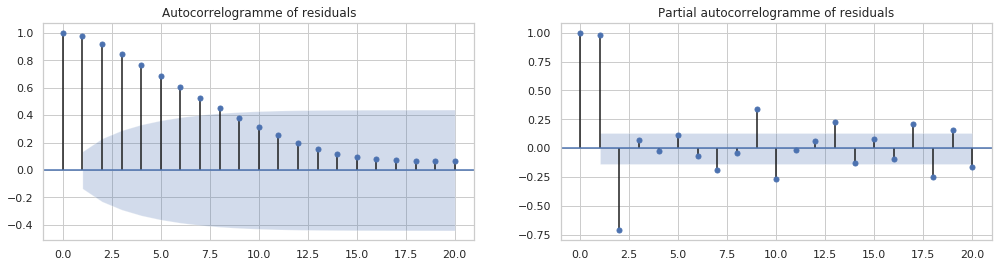

In [12]:
# Calculate the residuals
residuals = y - predict_unemp

fig, axes = plt.subplots(1, 2, figsize=(17,4))
fig = sm.graphics.tsaplots.plot_acf(residuals,ax=axes[0], lags = 20)
axes[0].set_title("Autocorrelogramme of residuals")
fig = sm.graphics.tsaplots.plot_pacf(residuals, ax=axes[1], lags = 20)
axes[1].set_title("Partial autocorrelogramme of residuals")
plt.show()

__Comment__ 

There seems to see a strong correlation between the $U_t$ and $U_{t-1}$. Let's try to modelize a AR(1) model for the residuals and evaluateif the parameters is  equal to 0. 

Let's put the following model AR(1): $U_t = \rho * U_{t-1} + e_t$
We will test the hypothesis $H_0 : [\rho = 0 ]$

In [13]:
X_res = residuals[:-1].reshape(-1,1)
y_res = residuals[1:]

beta_res, u_res, sig2_res, std_res, t_res, SSR_res, p_value_res = compute_pvalue_stat(X=X_res,y=y_res, nbVar= 1 )

In [14]:
print("The value of rho is {:.4f}".format(beta_res[0]))
print("The p-value for the test H0 is {:.2f}".format(p_value_res[0]))

The value of rho is 0.9808
The p-value for the test H0 is 0.00


We strongly reject $H_0$ and confirm what the graph already told us, which is there is a strong correlation of the residuals.

### Autocorrelation correction

As discussed in the previous part, there is a autocorrelation on the residual. Therefore, we can assume the relationship : 

$u_t = \rho * u_{t-1}+ e_t, for t = 1,2,...n$ and $0< |\rho| < 1 $. 

This autocorrelation creates a bias in the MCO, which is why our previous MCO give us a bad model. 
To correct this autocorrelation of residuals, we will proceed in three step. 

- evaluate $\rho$ (done in previous part)
- Define the transformed variables $\tilde{y_t} = (y_t - \rho * y_t-1) $ and $\tilde{X_t} = (X_t - \rho * X_t-1) $
- Do a MCO on those two transformed variables

In [15]:
# Transformed variables. 
rho = beta_res[0]
y_tilde = y[1:] - rho * y[:-1]
y_tilde = np.insert(y_tilde,0,np.sqrt(1-rho**2)*y[0])

X_tilde = X[1:] - rho * X[:-1]
X_tilde = np.insert(X_tilde,0,np.sqrt(1-rho**2)*X[0])

In [16]:
reg_correct = LinearRegression().fit(X_tilde.reshape(-1, 1), y_tilde)
predict_unemp_correct = reg_correct.predict(X_tilde.reshape(-1, 1))

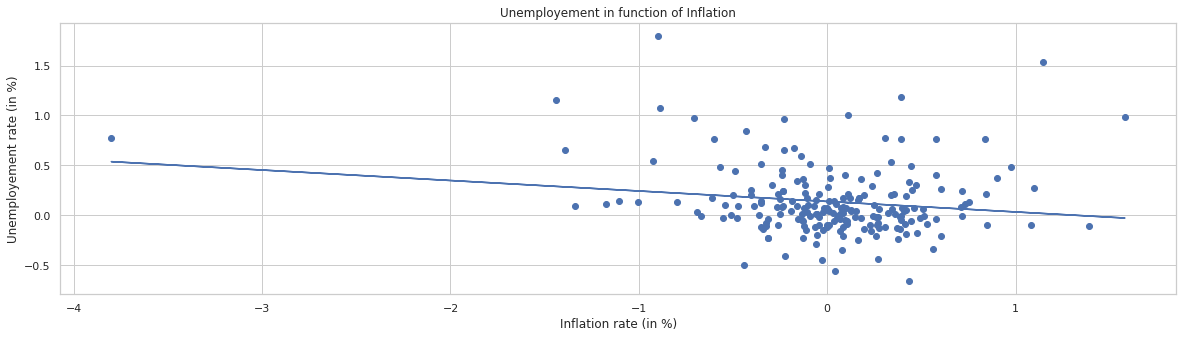

Intercept value : 0.137
Beta (Inflation) value : -0.10510


In [17]:
# Corrected plot
plt.figure(figsize = (20,5))
plt.scatter(X_tilde, y_tilde)
plt.plot(X_tilde, predict_unemp_correct)
plt.ylabel("Unemployement rate (in %)")
plt.xlabel("Inflation rate (in %)")
plt.title("Unemployement in function of Inflation")
plt.show()
print("Intercept value : {:.3f}".format(reg_correct.intercept_))
print("Beta (Inflation) value : {:.5f}".format(reg_correct.coef_[0]))

__Comment__ A first level of correction does not seems to be significant yet. If we do a autocorrelation of the residuals, we will see there is still is one strong autocorellation (because they were two levels of autocorrelation). Therefore, corrected the residuals does not seems to be enough for the problem. 

### Stability testing
We test the stability of the unemployment-inflation relationship over two sub-periods of the same size.

The goal of this part is to test if the coefficient of the regression are stable accros two subperiods. 

To test this hypothesis, we will do  a chow statistics on two intervalles $I_1 and I_2$ of same length.

We define the unrestricted model as : 

$Unemp = \beta_{1,0} + \beta_{1,1}*Inf$ : Regression on Intervales $I_1$

$Unemp = \beta_{2,0} + \beta_{2,1}*Inf$ : Regression on Intervales $I_2$

Then $SSR_{unr} = SSR_1 + SSR_2$ 

We define the restricted model as : 

$Unemp = \beta_{1,r} + \beta_{1,r}*Inf$ : Regression on Intervales $I_1$ and $I_2$

Let's caculate the SSR for both modelµ

In [18]:
# Definition of tge dataset for our 2 Intervales of 20 years each
df_I1 = df['1961':'1980'][['Unemp','Inf']]
df_I2 = df['1991':'2010'][['Unemp','Inf']]

# Define variables for unrestricted model 
n_I = df_I1.shape[0]
X_I1 = np.c_[np.ones((n_I,1)), df_I1['Inf'].values]
y_I1= df_I1['Unemp']

X_I2 = np.c_[np.ones((n_I,1)), df_I2['Inf'].values]
y_I2 = df_I2['Unemp']

# Define variables of the restricted model 
n_r = 2 * n_I 
X_Ir = np.c_[np.ones((n_r,1)), pd.concat([df_I1,df_I2])['Inf'].values]
y_Ir = pd.concat([df_I1,df_I2])['Unemp']

In [19]:
# Calculate the SSR for both model
beta_I1, _, _, _, _, SSR_I1, _ = compute_pvalue_stat(X_I1,y_I1,X_I1.shape[1])
beta_I2, _, _, _, _, SSR_I2, _ = compute_pvalue_stat(X_I2,y_I2,X_I2.shape[1])

beta_Ir, _, _, _, _, SSR_Ir, _ = compute_pvalue_stat(X_Ir,y_Ir,X_Ir.shape[1])

Let's calculate the chow statistic : 
$F = \frac{SSR_r - (SSR_1+SSR_2)}{(SSR_1+SSR_2)} * \frac{n-k_{unr}}{q}$

In this case : 
- n = 160 : because each intervals include 80 samples.
- $k_{unr} = 2 (1+1) = 4 $ because one 2 variables (including intercept) and 2 models. 
- q = 2 because we have 2 less variables in the restricted intercept.


In [20]:
F = (SSR_Ir - SSR_I1 - SSR_I2) / (SSR_I1+SSR_I2) * (160-4)/2
p_val = 1- stats.f.cdf(F, 2, 160-4)
print('The Beta factors for intervals 1 are : B0 = {:.3f} , B1 = {:.3f}'.format(beta_I1[0],beta_I1[1]))
print('The Beta factors for intervals 2 are : B0 = {:.3f} , B1 = {:.3f}'.format(beta_I2[0],beta_I2[1]))
print('The Beta factors for the restricted model are : B0 = {:.3f} , B1 = {:.3f}'.format(beta_Ir[0],beta_Ir[1]))
print('The p_value for our F statistic test is {:.3f}'.format(p_val))

The Beta factors for intervals 1 are : B0 = 5.103 , B1 = 0.358
The Beta factors for intervals 2 are : B0 = 6.235 , B1 = -0.615
The Beta factors for the restricted model are : B0 = 5.668 , B1 = 0.049
The p_value for our F statistic test is 0.012


We can reject at 5 % that the regression is stable among the 2 Intervals. 

### Chow test
We perform Chow structure change tests and detect the breaking point.

Based on the previous part, we know there is a structural change during the time which change the OLS variables. 

Therefore, we will do a test of chow accross time to find when the structural change occurs. 

To do so, let's assume $\tau$ a time period between '1965Q1' and '2007Q4' (we put a 5 years trimming). 

We assume the model, 

$Unemp = \beta_{1,0} + \beta_{1,1}*Inf$ : Regression before $\tau$

$Unemp = \beta_{2,0} + \beta_{2,1}*Inf$ : Regression after $\tau$

Therefore, we can put the unrestricted model : 
$Unemp = \beta_{0} + \beta_{1}*Inf + \gamma_0 D_{\tau}(t) + \gamma_1 D_{\tau}(t)* Inf  $ 

with $D_{\tau}(t) = 0$ if $t<\tau $ and equal to 1 otherwise.

and the restricted model : 

$Unemp = \beta_{0} + \beta_{1}*Inf $ 

For each value of $\tau$, we will test the hypothesis $H_0 = [\gamma_0 = 0 , \gamma_1 = 0]$
using the F-statistics 

$F = \frac{SSR_r - SSR_{ur}}{ SSR{ur}} *\frac{n-4}{2} $

Then we choose the rupture point $t_{rup} = max_{\tau}(F)$

In [21]:
# Let's define a function that given a time 𝜏, it will calculate the F statistics of the model
t_test = '1980Q1'
df_chow = df.iloc[1:][['Unemp','Inf']] 

def compute_chow_value(t_chow, df_chow):
    n = df_chow.shape[0] # number of total samples 
    n_tau = df_chow[:t_chow].shape[0]-1 #number of samples before 
    diag_tau = np.r_[np.zeros(n_tau), np.ones(n-n_tau)] # diagonal of the D_tau matrix
    D_tau = np.diag(diag_tau)

    y_chow = df_chow['Unemp']

    # Unrestricted model
    X_chow_unr = np.c_[np.ones((n,1)), df_chow['Inf'].values, D_tau@np.ones((n,1)), D_tau@df_chow['Inf'].values] 
    # Restricted model
    X_chow_r = np.c_[np.ones((n,1)), df_chow['Inf'].values] 
    
    # Calculate SSR for both model
    _, _, _, _, _, SSR_unr, _ = compute_pvalue_stat(X_chow_unr,y_chow,X_chow_unr.shape[1])
    _, _, _, _, _, SSR_r, _ = compute_pvalue_stat(X_chow_r,y_chow,X_chow_r.shape[1])
    
    # Calculate the F statistics 
    F = (SSR_r - SSR_unr) / SSR_unr * (n-4/2)
    return F

In [22]:
df_chow = df.iloc[1:][['Unemp','Inf']]  # do not take 1960Q1 which is Nan for Inf
tau_range = pd.date_range(start='1965', end='2008', freq='Q') # between 1965Q1 and 2007Q4
F_values = []
for tau in tau_range : 
    F_tau = compute_chow_value(tau, df_chow)
    F_values = F_values + [F_tau]

In [23]:
t_rup = str(tau_range[np.argmax(F_values)].year) + 'Q' + str(str(tau_range[np.argmax(F_values)].quarter))
print('The optimum point of structure is detected for '+t_rup)

The optimum point of structure is detected for 1970Q4


### Adding lag
We estimate the Philips curve by removing current inflation from the explanatory variables but adding the lags of order 1, 2, 3 and 4 of inflation and unemployment. We do the Granger test of non-causality of inflation on unemployment.

In this part we evaluate the following model : 

$Unemp_t = \beta_{0} + \beta_{1}Inf_{t-1} + \beta_{2}Inf_{t-2} + \beta_{3}Inf_{t-3} + \beta_{4}Inf_{t-4} + \beta_{5}Unemp_{t-1}+ \beta_{6}Unemp_{t-2}+ \beta_{7}Unemp_{t-3}+ \beta_{8}Unemp_{t-4} $

In [24]:
df_delay = df.iloc[1:][['Unemp','Inf']] # do not take first row with Nan

# Create the delayed variables
df_delay['Unemp_t-1'] = df_delay['Unemp'].shift(1)
df_delay['Unemp_t-2'] = df_delay['Unemp'].shift(2)
df_delay['Unemp_t-3'] = df_delay['Unemp'].shift(3)
df_delay['Unemp_t-4'] = df_delay['Unemp'].shift(4)
df_delay['Inf_t-1'] = df_delay['Inf'].shift(1)
df_delay['Inf_t-2'] = df_delay['Inf'].shift(2)
df_delay['Inf_t-3'] = df_delay['Inf'].shift(3)
df_delay['Inf_t-4'] = df_delay['Inf'].shift(4)

df_delay = df_delay.iloc[4:] # drop the row with Nan values 
df_delay.head(10)

,Unemp,Inf,Unemp_t-1,Unemp_t-2,Unemp_t-3,Unemp_t-4,Inf_t-1,Inf_t-2,Inf_t-3,Inf_t-4
DATE,,,,,,,,,,
1961Q2,7.00,-0.033512,6.80,6.27,5.53,5.23,0.201478,0.642109,0.067636,0.578231
1961Q3,6.77,0.402280,7.00,6.80,6.27,5.53,-0.033512,0.201478,0.642109,0.067636
1961Q4,6.20,0.133556,6.77,7.00,6.80,6.27,0.402280,-0.033512,0.201478,0.642109
1962Q1,5.63,0.400133,6.20,6.77,7.00,6.80,0.133556,0.402280,-0.033512,0.201478
1962Q2,5.53,0.365327,5.63,6.20,6.77,7.00,0.400133,0.133556,0.402280,-0.033512
1962Q3,5.57,0.297816,5.53,5.63,6.20,6.77,0.365327,0.400133,0.133556,0.402280
1962Q4,5.53,0.230947,5.57,5.53,5.63,6.20,0.297816,0.365327,0.400133,0.133556
1963Q1,5.77,0.329164,5.53,5.57,5.53,5.63,0.230947,0.297816,0.365327,0.400133
1963Q2,5.73,0.164042,5.77,5.53,5.57,5.53,0.329164,0.230947,0.297816,0.365327


In [25]:
# Define the variables of the model 
n_delay = df_delay.shape[0]
X_delay = np.c_[np.ones((n_delay,1)), df_delay[['Inf_t-1','Inf_t-2','Inf_t-3','Inf_t-4',
                                                'Unemp_t-1','Unemp_t-2','Unemp_t-3','Unemp_t-4']].values]
y_delay= df_delay['Unemp']

beta_delay, u_delay, sig2_delay, std_delay, t_delay, SSR_delay, p_value_delay = compute_pvalue_stat(
    X_delay,y_delay,X_delay.shape[1])

In [26]:
variables = ['Intercept', 'Inf_t-1','Inf_t-2','Inf_t-3','Inf_t-4','Unemp_t-1','Unemp_t-2','Unemp_t-3','Unemp_t-4']
print('The Beta value are : \n')
for i,variables in enumerate(variables): 
    print(variables + ':\t' + '{:.4f}'.format(beta_delay[i]))

The Beta value are : 

Intercept:	0.1457
Inf_t-1:	0.0311
Inf_t-2:	-0.0236
Inf_t-3:	0.0689
Inf_t-4:	0.0163
Unemp_t-1:	1.5937
Unemp_t-2:	-0.6472
Unemp_t-3:	0.0222
Unemp_t-4:	-0.0080


Let's due a test of no causality, aka Test de granger on the Inflation variables. 
We assume the hypothesis $ H_0 : [\beta_1 = 0 , \beta_2 = 0, \beta_3 = 0 , \beta_4 = 0]$

The unrestrained model is the one modelises above. 

The restrained model is : 

$Unemp_t = \beta_{0} + \beta_{1}Unemp_{t-1}+ \beta_{2}Unemp_{t-2}+ \beta_{3}Unemp_{t-3}+ \beta_{4}Unemp_{t-4} $

Let's calculate the F statistics.

In [27]:
# definition of restrained variables 
X_delay_r = np.c_[np.ones((n_delay,1)), df_delay[['Unemp_t-1','Unemp_t-2','Unemp_t-3','Unemp_t-4']].values]

beta_delay_r, _, _, _, _, SSR_delay_r, _ = compute_pvalue_stat(X_delay_r,y_delay,X_delay_r.shape[1])

In [28]:
# F statistics score with the according p_value
F_delay = (SSR_delay_r - SSR_delay) / (SSR_delay) * (n_delay-9)/4
p_val_delay = 1- stats.f.cdf(F, 4, n_delay-9)
print('The p_value for our F statistic test is {:.4f}'.format(p_val_delay))

The p_value for our F statistic test is 0.0016


We reject $H_0$ at 1 %. Therefore the variables $Inf_{t-1} , Inf_{t-2} , Inf_{t-3} ,Inf_{t-4}$ are significant in the model

### Plot of delays

In [29]:
lbls = np.array(["intercept",'Inf_t-1','Inf_t-2','Inf_t-3','Inf_t-4','Unemp_t-1','Unemp_t-2','Unemp_t-3','Unemp_t-4']) 

In [30]:
beta_delay.shape

(9,)

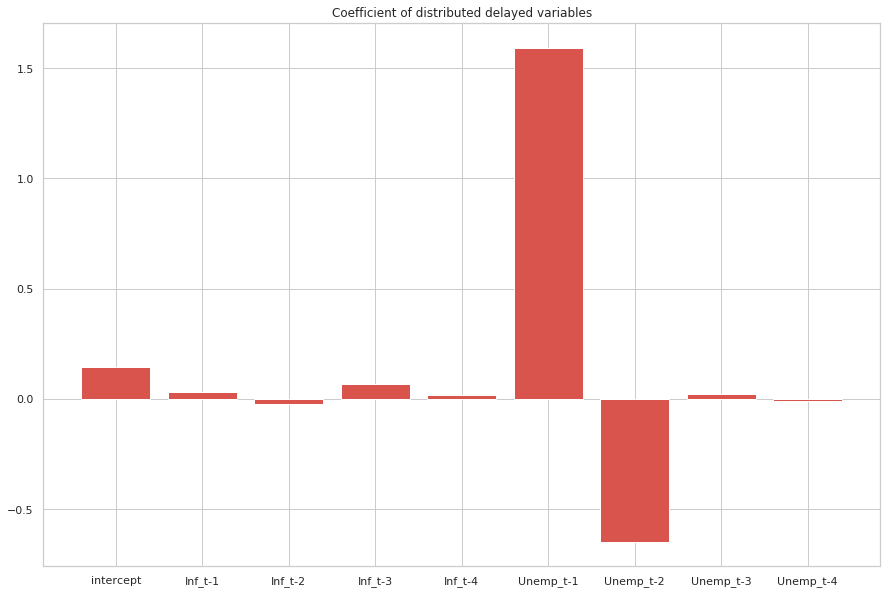

In [31]:
plt.figure(figsize = (15,10))
plt.bar(lbls,beta_delay, color = sns.xkcd_rgb["pale red"])
plt.title("Coefficient of distributed delayed variables")
plt.show()

__Comment__ 

The Unempt at t-1 and t-2 has an important impact on the Unempt for t. This is in coherence with the previous results where we saw that the residuals of time t-1 and t-2 had a great impact on the Unempts. 

The Inflation at t-3 is the variables with the most incidence amongs the distrinbuted variables. We can suggest that correspond to the necessary delays for a change in inflation to impact the Unpleyoment. 